<a href="https://colab.research.google.com/github/KirsaliAditya/stocksentiment/blob/main/stocksentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('all-data.csv', names=["Sentiment", "News Headline"], encoding='latin-1')
df.head()

,Sentiment,News Headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
# adding labels 0 for negative, 1 for neutral, 2 for positive

df['label'] = df['Sentiment'].map({
    'negative': 0,
    'neutral': 1,
    'positive': 2
})

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["News Headline"], df["label"], test_size=0.2, random_state=42
)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, headlines, labels, tokenizer, max_length=128):
        self.headlines = headlines
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        text = str(self.headlines[idx])
        label = self.labels[idx]

        # Tokenize the text
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [ ]:
train_dataset = NewsDataset(train_texts.tolist(), train_labels.tolist(), tokenizer)
test_dataset = NewsDataset(test_texts.tolist(), test_labels.tolist(), tokenizer)

In [ ]:
# count the no of values in train_dataset and test_dataset
print(len(train_dataset))
print(len(test_dataset))

3876
970


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./finbert-fine-tuned",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [ ]:
!pip install torch
import torch
print(torch.cuda.is_available())

True


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.305100,0.303070
2,0.168100,0.321945
3,0.038700,0.445847
4,0.013500,0.442517


TrainOutput(global_step=972, training_loss=0.23763405726532694, metrics={'train_runtime': 434.209, 'train_samples_per_second': 35.706, 'train_steps_per_second': 2.239, 'total_flos': 1019827607113728.0, 'train_loss': 0.23763405726532694, 'epoch': 4.0})

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Calculate metrics
report = classification_report(true_labels, predicted_labels, target_names=['negative', 'neutral', 'positive'])

# Print the metrics
print(report)


              precision    recall  f1-score   support

    negative       0.88      0.88      0.88       110
     neutral       0.91      0.91      0.91       571
    positive       0.83      0.83      0.83       289

    accuracy                           0.88       970
   macro avg       0.87      0.87      0.87       970
weighted avg       0.88      0.88      0.88       970



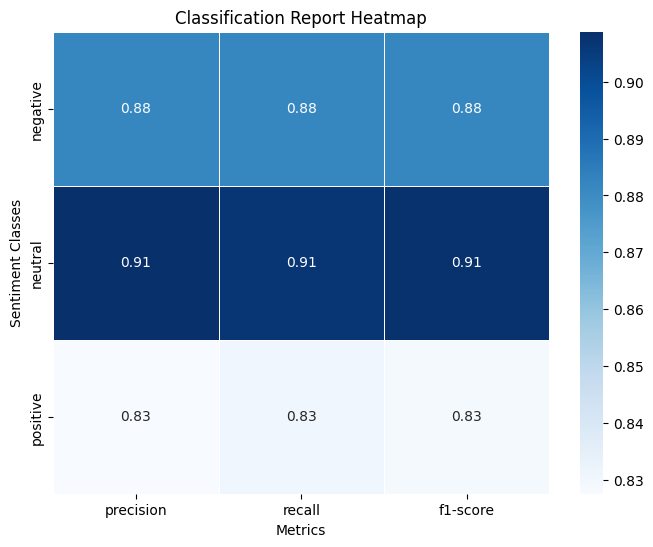

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(true_labels, predicted_labels, target_names=['negative', 'neutral', 'positive'], output_dict=True)

report_df = pd.DataFrame(report_dict).transpose()

metrics_df = report_df.loc[['negative', 'neutral', 'positive'], ['precision', 'recall', 'f1-score']]

plt.figure(figsize=(8, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", fmt=".2f", cbar=True, linewidths=0.5)
plt.title("Classification Report Heatmap")
plt.ylabel("Sentiment Classes")
plt.xlabel("Metrics")
plt.show()

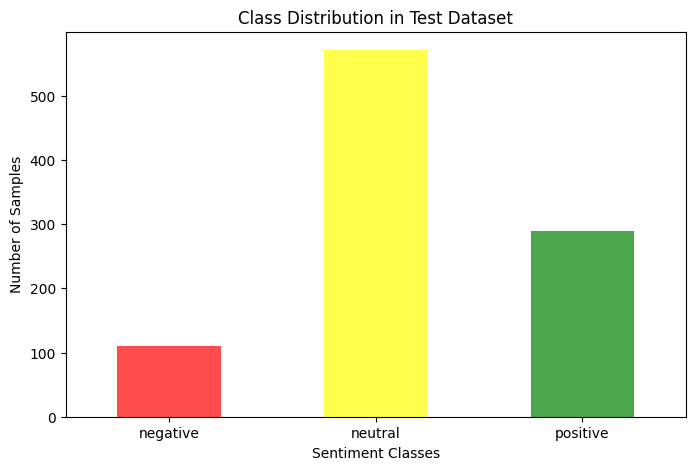

In [ ]:
# Extract support values for each class
support = report_df.loc[['negative', 'neutral', 'positive'], 'support']

# Bar chart for class distribution
plt.figure(figsize=(8, 5))
support.plot(kind='bar', color=['red', 'yellow', 'green'], alpha=0.7)
plt.title("Class Distribution in Test Dataset")
plt.xlabel("Sentiment Classes")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.show()

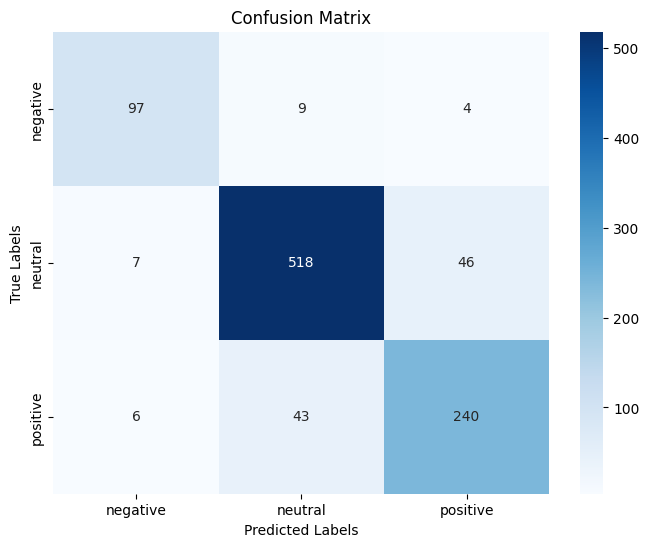

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# Save the fine-tuned model and tokenizer
model.save_pretrained("./finbert-fine-tuned")
tokenizer.save_pretrained("./finbert-fine-tuned")


('./finbert-fine-tuned/tokenizer_config.json',
 './finbert-fine-tuned/special_tokens_map.json',
 './finbert-fine-tuned/vocab.txt',
 './finbert-fine-tuned/added_tokens.json',
 './finbert-fine-tuned/tokenizer.json')

In [ ]:
!zip -r finbert-fine-tuned.zip ./finbert-fine-tuned

  adding: finbert-fine-tuned/ (stored 0%)
  adding: finbert-fine-tuned/tokenizer.json (deflated 71%)
  adding: finbert-fine-tuned/checkpoint-243/ (stored 0%)
  adding: finbert-fine-tuned/checkpoint-243/scheduler.pt (deflated 56%)
  adding: finbert-fine-tuned/checkpoint-243/trainer_state.json (deflated 74%)
  adding: finbert-fine-tuned/checkpoint-243/training_args.bin (deflated 51%)
  adding: finbert-fine-tuned/checkpoint-243/optimizer.pt (deflated 23%)
  adding: finbert-fine-tuned/checkpoint-243/config.json (deflated 50%)
  adding: finbert-fine-tuned/checkpoint-243/model.safetensors (deflated 7%)
  adding: finbert-fine-tuned/checkpoint-243/rng_state.pth (deflated 25%)
  adding: finbert-fine-tuned/checkpoint-486/ (stored 0%)
  adding: finbert-fine-tuned/checkpoint-486/scheduler.pt (deflated 56%)
  adding: finbert-fine-tuned/checkpoint-486/trainer_state.json (deflated 78%)
  adding: finbert-fine-tuned/checkpoint-486/training_args.bin (deflated 51%)
  adding: finbert-fine-tuned/checkpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the model to your Google Drive
!cp -r ./finbert-fine-tuned /content/drive/MyDrive/

Mounted at /content/drive
